# **Data Visualization Notebook**

## Objectives

* Answer business requirement 1:
    * The client is interested in conducting a study to visually differentiate a cherry leaf that is healthy from one that contains powdery mildew.

## Inputs

* inputs/dataset/cherry-leaves/test
* inputs/dataset/cherry-leaves/train
* inputs/dataset/cherry-leaves/validation

## Outputs

* Image shape embeddings pickle file.
* Mean and variability of images per label plot.
* Plot to distinguish the contrast between average healthy cherry leaves and a cherry leaves with powdery mildew.
* Generate code that answers business requirement 1 and can be used to build an image montage on the Streamlit dashboard.

## Additional Comments

* The code in this notebook was taken from Code Institue Malaria Detector Walkthrough Sample Project and adapted to suit this project.

---

# Set Data Directory

Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set_style("white")
from matplotlib.image import imread

Set working directory

In [2]:
cwd = os.getcwd()

In [3]:
os.chdir('/workspaces/mildew-detection-in-cherry-leaves')
print("You set a new working directory")

You set a new working directory


Confirm the new current directory

In [4]:
work_dir = os.getcwd()
work_dir

'/workspaces/mildew-detection-in-cherry-leaves'

# Set Input Directories

Set train, validation and test paths.

In [5]:
my_data_dir = 'inputs/dataset/cherry-leaves'
train_path = my_data_dir + '/train' 
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

---

# Set Output Directories

Set outputs directory and create a subdirectory to store each different version of output created.

In [6]:
version = 'v2'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


# Set Label Names

In [7]:
labels = os.listdir(train_path)
print('Labels for the images are', labels)

Labels for the images are ['healthy', 'powdery_mildew']


---

# Data visualization of image data

---

## Image Shape

Compute the average image size on train set.

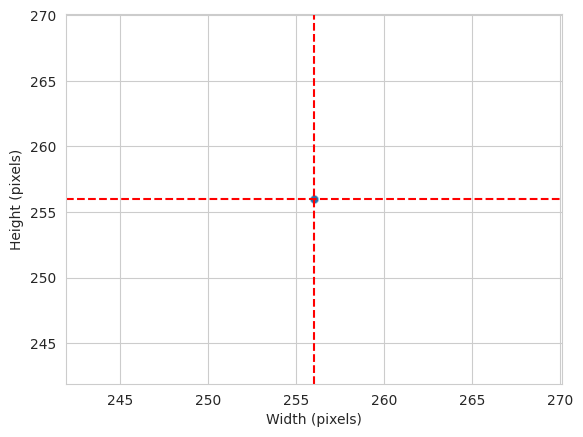

Width average: 256 
Height average: 256


In [8]:
height, width = [], []
for label in labels:
    for image_filename in os.listdir(train_path + '/' + label):
        img = imread(train_path + '/' + label + '/' + image_filename)
        h, w, colors = img.shape
        height.append(h)
        width.append(w)

sns.set_style('whitegrid')
fig, axes = plt.subplots()
sns.scatterplot(x=width, y=height, alpha=0.2)
axes.set_xlabel('Width (pixels)')
axes.set_ylabel('Height (pixels)')
height_mean = int(np.array(height).mean())
width_mean = int(np.array(width).mean())
axes.axvline(x=height_mean, color='r', linestyle='--')
axes.axhline(y=width_mean, color='r', linestyle='--')
plt.show()
print(f'Width average: {width_mean} \nHeight average: {height_mean}')

Defing an image of 256 x 265 pixels to load the images to memory for training the model would result in a trained model that will likely be larger than 100Mb. To avoid the need to push large files to Github, a smaller image shape will be used.


In [9]:
image_shape = (100,100,3) # 100x100 pixels, 3 color channels (rgb)

Save the image shape embeddings

In [10]:
joblib.dump(value=image_shape ,
            filename=f"{file_path}/image_shape.pkl")

['outputs/v2/image_shape.pkl']

---

# Average and Variability of Images Per Label

## Function to load images in an array (tensor)

Load the image shape and label in an array. The function takes data path, size of the images, and the (maximum) number of images per label. The images and their dimensions are loaded using the image function from the TensorFlow package. They are then scaled and reshaped to the new dimensions (number of images, height, width, and color gradient) before being stored in an X array variable. The image pixel intensity values are also normalized to values between 0 and 1, this helps to speed up model learning. The label names for each image stored in the X array variable, are stored in the y array variable. The function returns the X and y array variables to use when plotting the mean and variability of images per label.

In [11]:
from tensorflow.keras.preprocessing import image


def load_image_as_array(my_data_dir, new_size=(50, 50), n_images_per_label=20):
    """
    Load resized/rescaled images in an array (tensor).
    
    Args:
        my_data_dir: str: data directory filepath
        new_size: tuple: target dimensions to resize images
        n_images_per_label: int: number of images to load into array per label

    Returns:
        X: array: image shape
        y: array: labels
    """

    X, y = np.array([], dtype='int'), np.array([], dtype='object')
    labels = os.listdir(my_data_dir)

    for label in labels:
        counter = 0
        for image_filename in os.listdir(my_data_dir + '/' + label):
            if counter < n_images_per_label:

                img = image.load_img(
                    my_data_dir + '/' + label + '/' + image_filename, target_size=new_size)
                if image.img_to_array(img).max() > 1:
                    img_resized = image.img_to_array(img) / 255
                else:
                    img_resized = image.img_to_array(img)

                X = np.append(X, img_resized).reshape(-1,
                                                      new_size[0], new_size[1], img_resized.shape[2])
                y = np.append(y, label)
                counter += 1

    return X, y

## Load image shapes and labels in an array

Load image shapes and labels of 30 images into arrays from the training set
in X and y variables, and print out their shape. These variables will be used to plot the mean and variability of images per label.

In [12]:
X, y = load_image_as_array(my_data_dir=train_path,
                           new_size=image_shape,
                           n_images_per_label=30)
print(X.shape, y.shape)

(60, 100, 100, 3) (60,)


## Plot and save mean and variability of images per label

In [13]:
def plot_mean_variability_per_labels(X, y, figsize=(12, 5), save_image=False):
    """
    - Loop over all image labels
    - create subsets of each label
    - caluculate the mean and standard deviation
    - create a figure displaying the mean and variablity of the images
    - save the image in the output folder

    Args:
        X: array: image shape
        y: array: labels
        figsize: tuple: Define figure size of the plot. Default: (12, 5).
        save_image: boolean: Flag to save the plots. Default: False.

    Returns:
        None
    """

    for label_to_display in np.unique(y):
        sns.set_style("white")

        y = y.reshape(-1, 1, 1)
        boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
        arr = X[boolean_mask]

        avg_img = np.mean(arr, axis=0)
        std_img = np.std(arr, axis=0)
        print(f"==== Label {label_to_display} ====")
        print(f"Image Shape: {avg_img.shape}")
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
        axes[0].set_title(f"Average image for label {label_to_display}")
        axes[0].imshow(avg_img, cmap='gray')
        axes[1].set_title(f"Variability image for label {label_to_display}")
        axes[1].imshow(std_img, cmap='gray')

        if save_image:
            plt.savefig(f"{file_path}/avg_var_{label_to_display}.png",
                        bbox_inches='tight', dpi=150)
        else:
            plt.tight_layout()
            plt.show()
            print("\n")

==== Label healthy ====
Image Shape: (100, 100, 3)
==== Label powdery_mildew ====
Image Shape: (100, 100, 3)


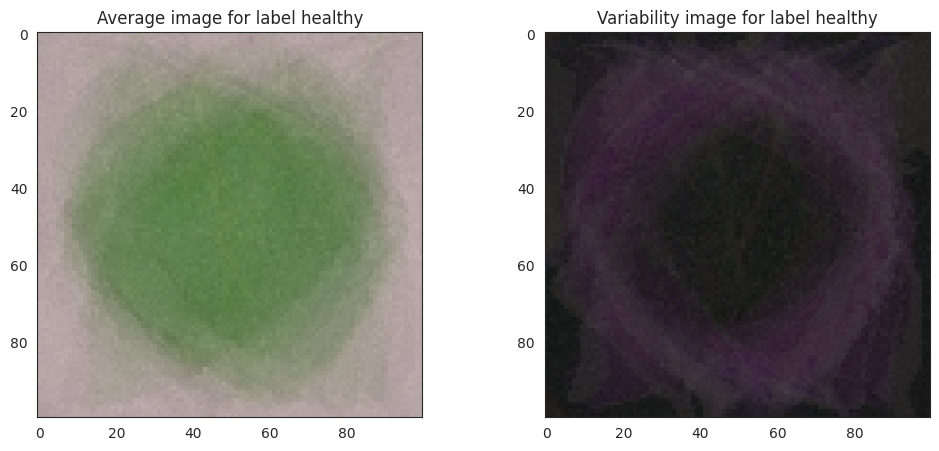

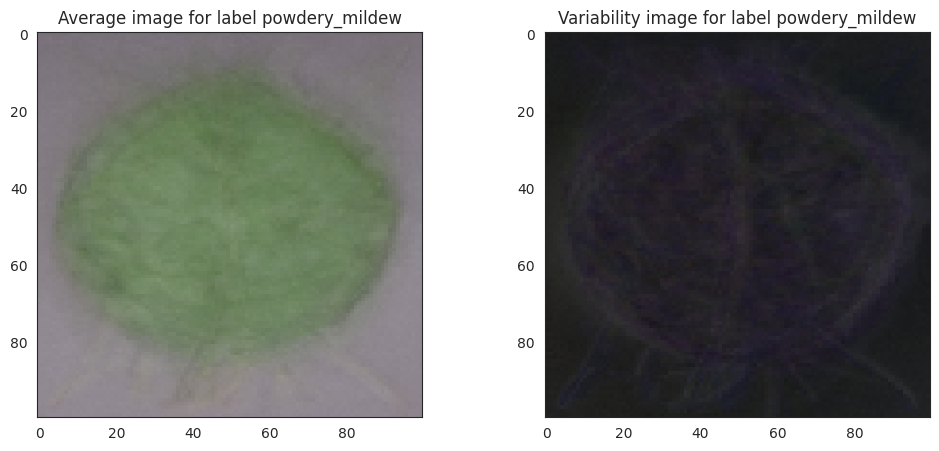

In [14]:
plot_mean_variability_per_labels(X=X, y=y, figsize=(12, 5), save_image=True)

---

# Difference Between Average Powdery-mildew Infected and Average Healthy Cherry Leaves

Plot the average image of the healthy leaves, an average image of powdery mildew infected leaves, and the difference between both average images.

In [15]:
def subset_image_label(X, y, label_to_display):
    """
    Create a subset of images of a given label.
    
    Args:
        X: array: image shape
        y: array: labels
        label_to_display: str: label name
    
    Returns:
        df: array: subset of images of given label, image shape
    """
    y = y.reshape(-1, 1, 1)
    boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
    df = X[boolean_mask]
    return df

In [16]:
def diff_bet_avg_image_labels_data_as_array(X, y, label_1, label_2, figsize=(20, 5), save_image=False):
    """
    Checks if the labels exist in the set of unique labels
    Calculates the mean and difference for label1 and label2
    Plots a chart and saves it if save_image=True

    Args:
        X: array: image shape
        y: array: labels
        label_1: str: label name
        label_2: str: label name
        figsize: tuple: Define figure size of the plot. Default: (20, 5)
        save_image: boolean: Flag to save the plots. Default: False

    Returns:
        None
    """
    sns.set_style("white")

    if (label_1 not in np.unique(y)) or (label_2 not in np.unique(y)):
        print(
            f"Either label {label} or label {label_2}, are not in {np.unique(y)} ")
        return

    # calculate mean from label1
    images_label = subset_image_label(X, y, label_1)
    label1_avg = np.mean(images_label, axis=0)

    # calculate mean from label2
    images_label = subset_image_label(X, y, label_2)
    label2_avg = np.mean(images_label, axis=0)

    # calculate difference and plot difference, avg label1 and avg label2
    difference_mean = label1_avg - label2_avg
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    axes[0].imshow(label1_avg, cmap='gray')
    axes[0].set_title(f'Average {label_1}')
    axes[1].imshow(label2_avg, cmap='gray')
    axes[1].set_title(f'Average {label_2}')
    axes[2].imshow(difference_mean, cmap='gray')
    axes[2].set_title(f'Difference image: Avg {label_1} & {label_2}')
    if save_image:
        plt.savefig(f"{file_path}/avg_diff.png", bbox_inches='tight', dpi=150)
    else:
        plt.tight_layout()
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


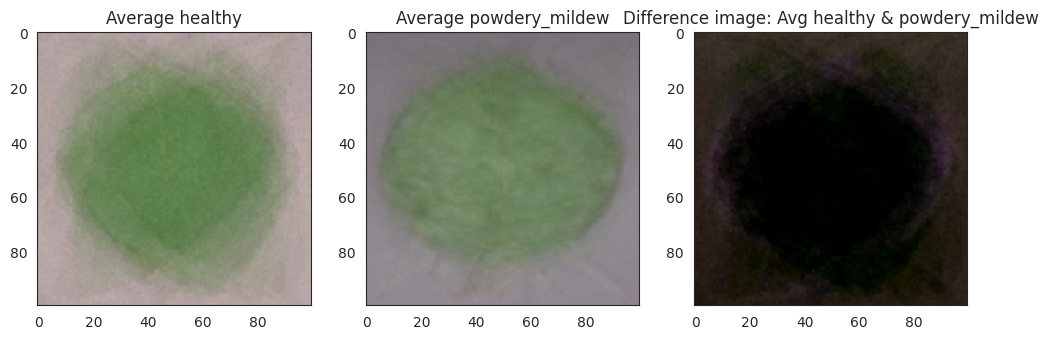

In [17]:
diff_bet_avg_image_labels_data_as_array(X=X, y=y,
                                        label_1='healthy', label_2='powdery_mildew',
                                        figsize=(12, 12),
                                        save_image=True
                                        )

---

# Image Montage

Create a gallery of images from the inputs folder of each label. The function first checks if the label exists in the directory, then checks if there are more images in the montage than in the subset of images. A list of axes indices is created based on number of rows and number of columns of the figure. The figure is created and the images looped over and plotted.

In [18]:
import itertools
import random
sns.set_style("white")


def image_montage(dir_path, label_to_display, nrows, ncols, figsize=(15, 10)):
    """
    Displays a montage of images from a directory subset for each label.

    Args:
    - dir_path (str): The filepath of the directory containing the image files.
    - label_to_display (str): The image label of the image subset to display.
    - nrows (int): The number of rows in the image montage.
    - ncols (int): The number of columns in the image montage.
    - figsize (tuple): The dimensions of the figure. Default (15, 10).

    Returns:
    - None
    """

    labels = os.listdir(dir_path)

    # subset the class you are interested to display
    if label_to_display in labels:

        # checks if your montage space is greater than the subset size
        images_list = os.listdir(dir_path + '/' + label_to_display)
        if nrows * ncols < len(images_list):
            img_idx = random.sample(images_list, nrows * ncols)
        else:
            print(
                f"Decrease nrows or ncols to create your montage. \n"
                f"There are {len(images_list)} in your subset. "
                f"You requested a montage with {nrows * ncols} spaces")
            return

        # create a list of axes indices based on nrows and ncols
        list_rows = range(0, nrows)
        list_cols = range(0, ncols)
        plot_idx = list(itertools.product(list_rows, list_cols))

        # create a Figure and display images
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
        for x in range(0, nrows*ncols):
            img = imread(dir_path + '/' + label_to_display + '/' + img_idx[x])
            img_shape = img.shape
            axes[plot_idx[x][0], plot_idx[x][1]].imshow(img)
            axes[plot_idx[x][0], plot_idx[x][1]].set_title(
                f"Width {img_shape[1]}px x Height {img_shape[0]}px")
            axes[plot_idx[x][0], plot_idx[x][1]].set_xticks([])
            axes[plot_idx[x][0], plot_idx[x][1]].set_yticks([])
        plt.tight_layout()
        plt.show()

    else:
        print("The label you selected doesn't exist.")
        print(f"The existing options are: {labels}")

healthy


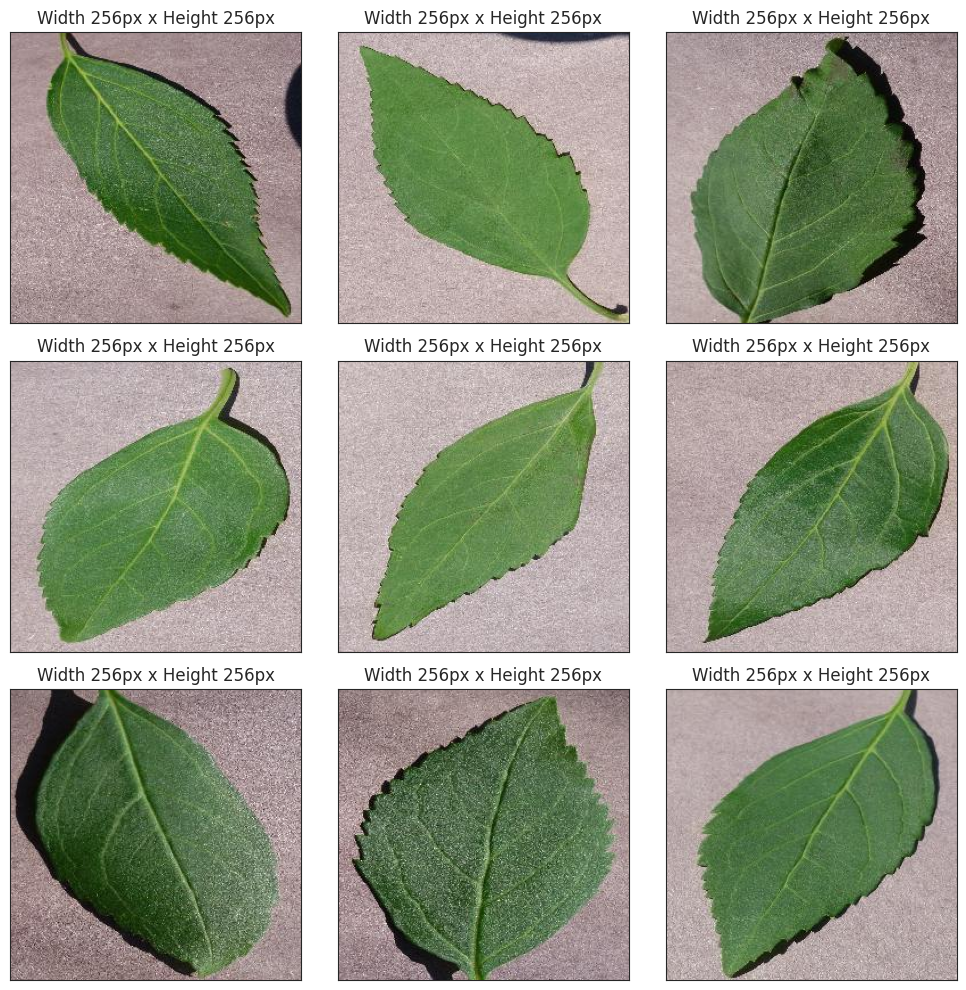



powdery_mildew


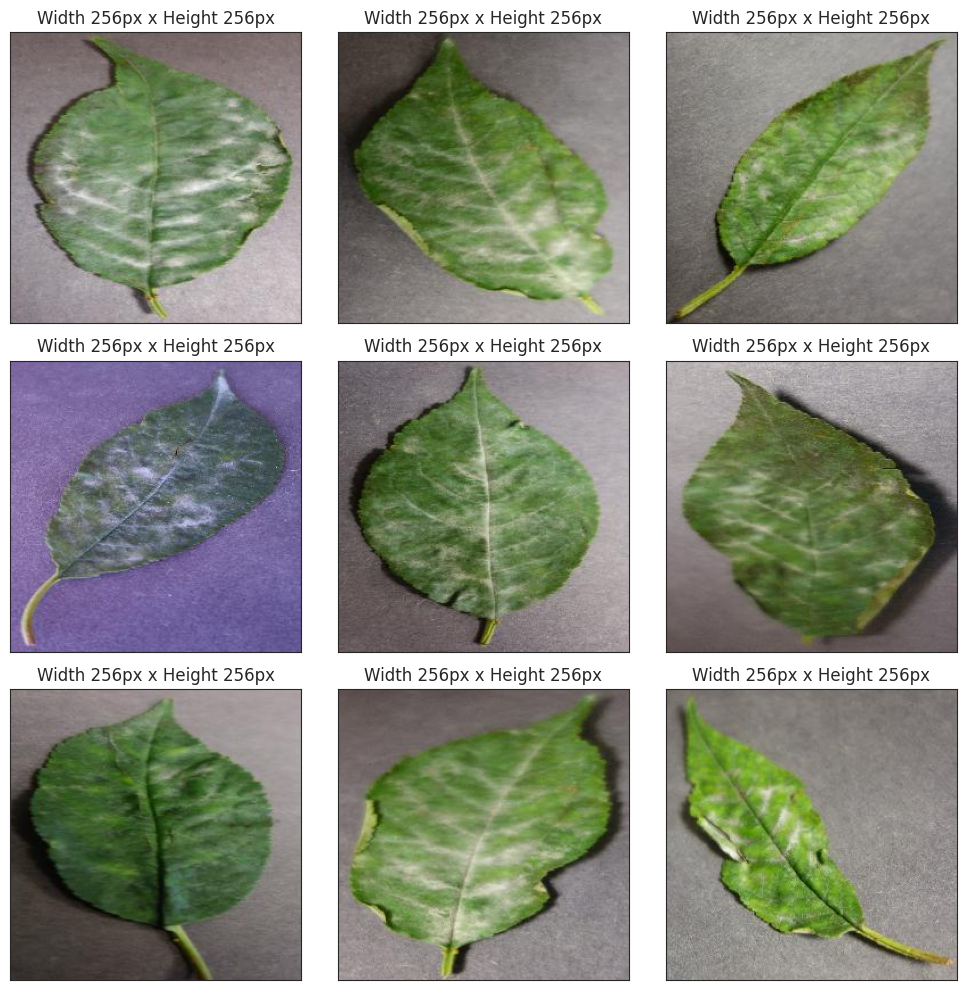

In [19]:
for label in labels:
    print(label)
    image_montage(dir_path=train_path,
                  label_to_display=label,
                  nrows=3, ncols=3,
                  figsize=(10, 10)
                  )
    print("\n")

---

# Conclusions and Next Steps

* Studying the average and variability of images per label highlighted that mildew infected cherry leaves exhibit more variation across the surface of the leaf. However, the study did not highlight any distinct patterns that could be used to intuitively differentiate between healthy and infected leaves.
* Studying the difference between average healthy and average powdery mildew cherry leaves did not highlight patterns where we could intuitively differentiate one from another.
* The image montage can be used to visually identify differences between a healthy leaf and a mildew infected one, and highlight typical signs of mildew infection.

The image shape embeddings pickle file will be used in developing an ML model capable of predicting whether a cherry leaf is healthy or contains powdery mildew.
